In [1]:
%matplotlib inline
import os, sys
import time
sys.path.append("../model/")

from model import PIC2PIC, DISCRIMINATOR, GENERATOR, PATCHBLOCK
from utils import HumanSegGenerator, load_dataset, gen_sample, plot_generated_batch, get_disc_batch

from keras.utils import generic_utils
from keras.optimizers import Adam, SGD
from keras.utils import plot_model
import keras.backend as K

import cv2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

/home/ksj/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


1. https://github.com/ChengBinJin/V-GAN-tensorflow/blob/master/codes/model.py
2. https://github.com/tdeboissiere/DeepLearningImplementations/blob/master/pix2pix/src/model/train.py
----


### Training details

Random jitter was applied by resizing the 256×256 input
images to 286 × 286 and then randomly cropping back to
size 256 × 256.

All networks were trained from scratch. Weights were
initialized from a Gaussian distribution with mean 0 and
standard deviation 0.02.

Maps↔aerial photograph 1096 training images
scraped from Google Maps, trained for 200 epochs, batch
size 1, with random jitter and mirroring. Images were
sampled from in and around New York City. Data was then
split into train and test about the median latitude of the
sampling region (with a buffer region added to ensure that
no training pixel appeared in the test set).

We use minibatch SGD and
apply the Adam solver [31], with learning rate 0.0002, and
momentum parameters β 1 = 0.5, β 2 = 0.999.

In addition, we divide the objective by 2 while optimizing D, which slows down the rate at
which D learns relative to G. We use minibatch SGD and
apply the Adam solver [31], with learning rate 0.0002, and
momentum parameters β 1 = 0.5, β 2 = 0.999.

In [2]:
model_name = "pix2pix"

batch_size = 1
nb_epoch = 70 # 1096 * 200 / 3500

img_dim = (256,256,3)
patch_size = (64,64)
nb_filter = 64
output_dim = (256,256,1)

nb_sample = 16

In [3]:
# set the model directory to save 
result_dir = "../results/{}/".format(model_name)
os.makedirs(result_dir, exist_ok=True)
# save weights
weights_dir = os.path.join(result_dir,'weights')
os.makedirs(weights_dir,exist_ok=True)
# save model diagram 
model_dir = os.path.join(result_dir, "model-arch")
os.makedirs(model_dir, exist_ok=True)
# save sample iamge
sample_dir = os.path.join(result_dir,"sample")
os.makedirs(sample_dir, exist_ok=True)

In [4]:
# create the model
patch_dim = *patch_size, output_dim[-1]
patchblock= PATCHBLOCK(patch_dim, img_dim, nb_filter)

generator = GENERATOR(img_dim, 16, output_dim)
discriminator = DISCRIMINATOR(output_dim, patch_size, nb_filter)

gan = PIC2PIC(generator, discriminator)

In [5]:
# draw the architecture diagram of model
model_path = os.path.join(model_dir, "patchblock.png")
plot_model(patchblock, to_file=model_path, show_shapes=True)

model_path = os.path.join(model_dir, "generator.png")
plot_model(generator, to_file=model_path, show_shapes=True)

model_path = os.path.join(model_dir, "discriminator.png")
plot_model(discriminator, to_file=model_path, show_shapes=True)

In [6]:
# set the optimizer
opt_generator = Adam(lr=2E-4, beta_1=0.5, beta_2=0.999)
opt_discriminator = Adam(lr=1E-4, beta_1=0.5, beta_2=0.999)

# set the loss function
discriminator.trainable = False
generator.compile(loss='mae', optimizer=opt_discriminator) # legacy for save_weights

loss = ['mean_absolute_error', 'binary_crossentropy']
loss_weights = [1e1, 1]
gan.compile(loss=loss, loss_weights=loss_weights, optimizer=opt_generator)

discriminator.trainable = True
discriminator.compile(loss='binary_crossentropy', optimizer=opt_discriminator)

In [7]:
# Split the train and test dataset
train, test = train_test_split(load_dataset(), test_size=409)

train_generator = HumanSegGenerator(train, img_dim, batch_size=1)
test_generator = HumanSegGenerator(test, img_dim, batch_size=1, is_train=True)

epoch_size = train.shape[0]
n_batch_per_epoch = epoch_size // batch_size

loss_df = pd.DataFrame()

TypeError: Invalid dimensions for image data

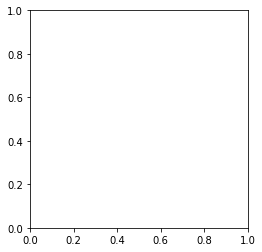

In [29]:
plt.imshow(inverse_normalization(X_disc[0]))

In [ ]:
step = 0
for e in range(nb_epoch):
    progbar = generic_utils.Progbar(epoch_size)
    start = time.time()
    for _ in range(n_batch_per_epoch):
        step += 1
        image_batch, profile_batch = next(train_generator)
        # Create a batch to feed the discriminator model
        X_disc, y_disc = get_disc_batch(image_batch, profile_batch, 
                                        generator, step, patch_size,label_smoothing=True)
        
        # Update the discriminator
        disc_loss = discriminator.train_on_batch(X_disc, y_disc)
        
        # Create a batch to feed the generator model
        y_gen = np.zeros((image_batch.shape[0], 2), dtype=np.uint8)
        y_gen[:, 1] = 1
        
        # Freeze the discriminator
        discriminator.trainable = False
        gen_loss = gan.train_on_batch(image_batch, [profile_batch, y_gen])
        # Unfreeze the discriminator
        discriminator.trainable = True
        
        # save and show the training progress
        loss_df = loss_df.append({
                "step" : step,
                "epoch" : e,
                "train D logloss" : disc_loss,
                "train G tot" : gen_loss[0],
                "train G L1" : gen_loss[1],
                "train G logloss": gen_loss[2],
            },ignore_index=True)
        
        progbar.add(batch_size, values=[("D logloss", disc_loss),
                                        ("G tot", gen_loss[0]),
                                        ("G L1", gen_loss[1]),
                                        ("G logloss", gen_loss[2])])
        
        # Save images for Visualization
        if step % (n_batch_per_epoch / 4) == 0:
            # Get new images from validation
            filename = "{}_{}".format(e, step//nb_epoch)
            sample_path = os.path.join(sample_dir,filename)
            
            image_sample, profile_sample = gen_sample(train_generator, nb_sample)
            plot_generated_batch(image_sample,profile_sample,generator,sample_path+"_train.png")
            image_sample, profile_sample = gen_sample(test_generator, nb_sample)
            plot_generated_batch(image_sample,profile_sample,generator,sample_path+"_test.png")
            loss_df.to_csv(os.path.join(sample_dir,"loss.csv"))
        
    if e % 10 == 0:
        gen_weights_path = os.path.join(weights_dir,"gen_weights_epoch{:03}.h5".format(e))
        generator.save_weights(gen_weights_path, overwrite=True)

        disc_weights_path = os.path.join(weights_dir,"disc_weights_epoch{:03}.h5".format(e))
        discriminator.save_weights(disc_weights_path, overwrite=True)

        gan_weights_path = os.path.join(weights_dir,"gan_weights_epoch{:03}.h5".format(e))
        gan.save_weights(gan_weights_path, overwrite=True)

  97/3500 [..............................] - ETA: 1:34:52 - D logloss: 0.6962 - G tot: 10.9239 - G L1: 0.9254 - G logloss: 1.6694

In [11]:
def inverse_normalization(X):
    # value range : (-1,1) => (0,1)
    res = (X + 1.) / 2.
    return np.clip(res, 0.,1.)

In [18]:
def plot_generated_batch(image_sample, profile_sample, generator, plot_path):
    nb_sample = image_sample.shape[0]
    rows = []
    for i in range(nb_sample):
        image = inverse_normalization(np.squeeze(image_sample[i]))
        real_profile = np.squeeze(inverse_normalization(profile_sample[i]))
        y = generator.predict(image_sample[i:i+1])
        fake_profile = np.squeeze(inverse_normalization(y))
        real_profile = np.stack([real_profile]*3,axis=-1)
        fake_profile = np.stack([fake_profile]*3,axis=-1)
        print(image.shape,real_profile.shape,fake_profile.shape)
        rows.append(np.concatenate([image, real_profile, fake_profile],axis=1))
    sample = np.concatenate(rows,axis=0)
    Image.fromarray((sample * 255).astype(np.uint8)).save(plot_path)